## Bayesian nonparametrics

**Author:** Felipe Tobar
**Date:** 29 January, 2025

**Statement of originality:** The conceptual structure and teaching narrative of this notebook are original. ChatGPT 5.2 was used as a coding assistant for parts of the low-level implementation and plotting. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt

print_figs = True


plt.rcParams.update({
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14,
    "lines.linewidth": 3,
})


### 1) Density estimation

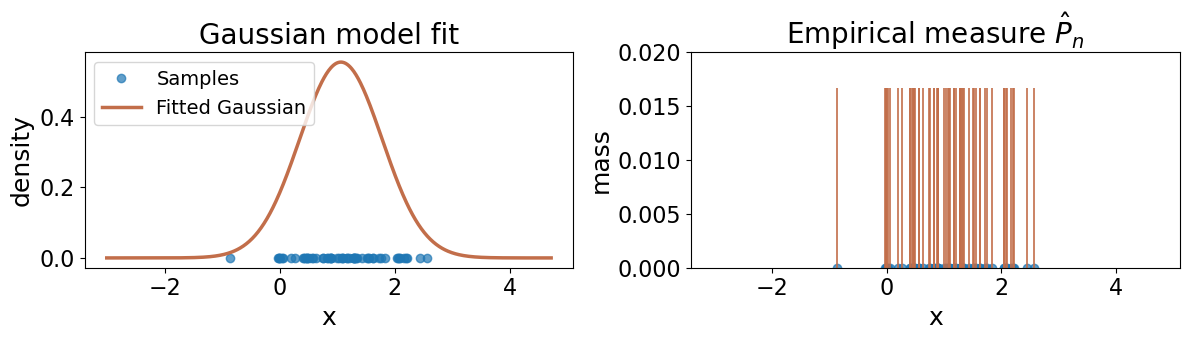

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- data: sample from a Gaussian ---
rng = np.random.default_rng(0)
n = 60
mu_true, sigma_true = 1.0, 0.8
x = rng.normal(mu_true, sigma_true, size=n)

# --- Gaussian fit (MLE) ---
mu_hat = x.mean()
sigma_hat = x.std(ddof=0)

# Grid for plotting the fitted Gaussian density
xx = np.linspace(x.min() - 3*sigma_hat, x.max() + 3*sigma_hat, 600)
gauss_pdf = (1.0 / (np.sqrt(2*np.pi) * sigma_hat)) * np.exp(
    -(xx - mu_hat)**2 / (2 * sigma_hat**2)
)

# ---------------- Side-by-side figures ----------------
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharex=True)

# (i) Samples + fitted Gaussian
axes[0].plot(x, np.zeros_like(x), "o", alpha=0.7, label="Samples")
axes[0].plot(xx, gauss_pdf, linewidth=2.5, color="#C26E4A", label="Fitted Gaussian")
axes[0].set_title("Gaussian model fit")
axes[0].set_xlabel("x")
axes[0].set_ylabel("density")
axes[0].legend()

# (ii) Empirical measure as Dirac masses
axes[1].plot(x, np.zeros_like(x), "o", alpha=0.7, label="Samples")
axes[1].vlines(x, 0.0, 1.0 / n, color="#C26E4A",linewidth=1.2)
axes[1].set_ylim(0, 1.2 / n)
axes[1].set_title(r"Empirical measure $\hat P_n$")
axes[1].set_xlabel("x")
axes[1].set_ylabel("mass")
plt.tight_layout()


if print_figs:
    plt.savefig("../img/week4_density_estimation_2methods.pdf", format="pdf", bbox_inches="tight")
    

In [23]:
### 2) Finite mixture

<>:31: SyntaxWarning: invalid escape sequence '\s'
<>:31: SyntaxWarning: invalid escape sequence '\s'
/var/folders/hd/761f4bvn2jz3pr3pm02m44k80000gn/T/ipykernel_30364/1659679017.py:31: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('$p(x) = \sum c_ip(x | \phi_i)$')


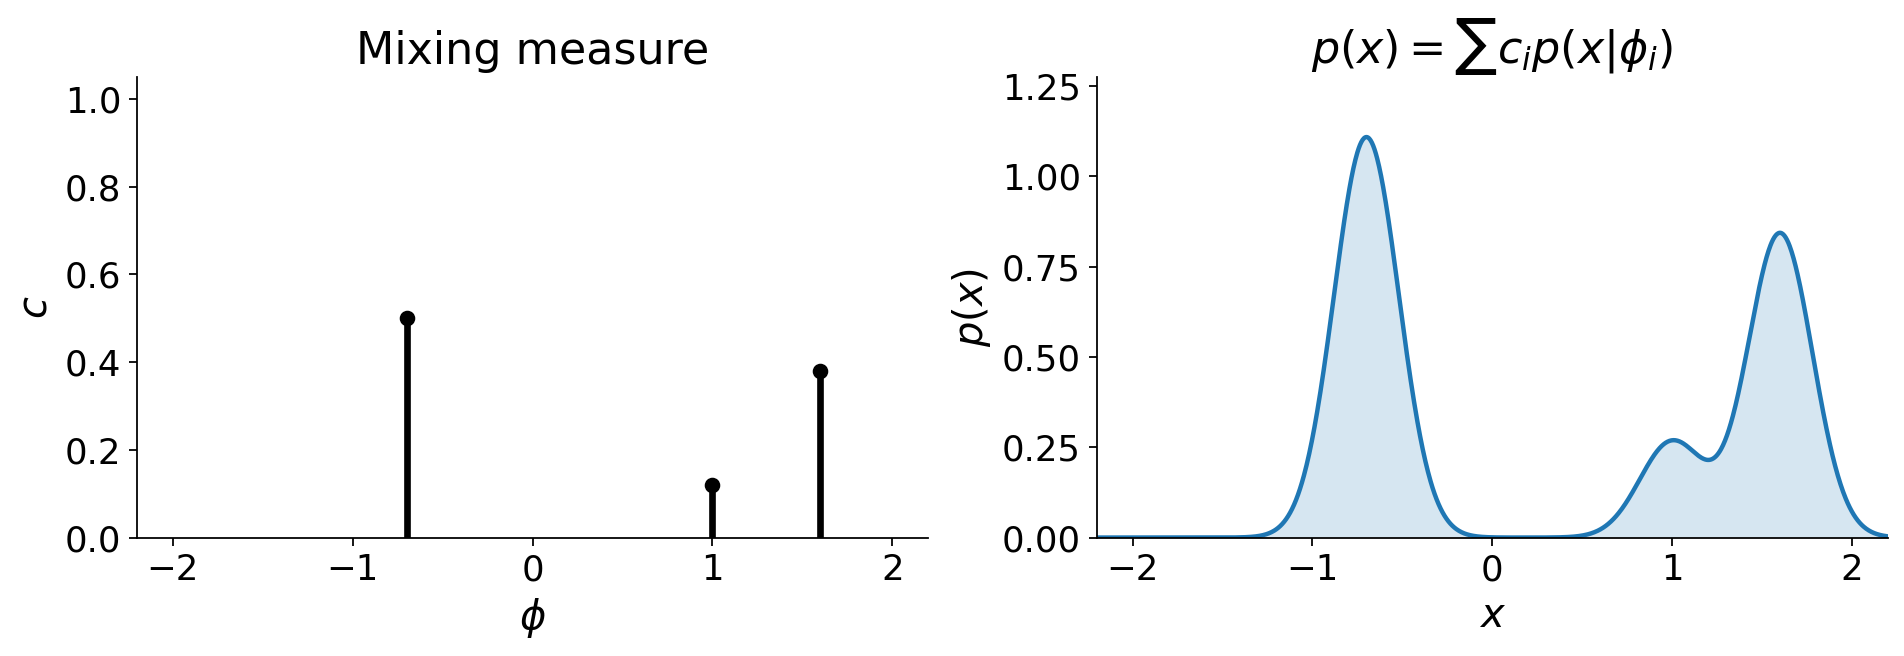

In [28]:
# --- Finite Gaussian mixture parameters (edit these to taste) ---
phi = np.array([-0.7, 1.0, 1.6])          # component locations (means)
c   = np.array([0.50, 0.12, 0.38])        # mixing weights (sum to 1)
sigma = 0.18                               # shared std. dev.

# --- Grid and mixture density ---
x = np.linspace(-2.2, 2.2, 1200)

def normal_pdf(x, mu, sig):
    return (1.0 / (np.sqrt(2*np.pi) * sig)) * np.exp(-(x - mu)**2 / (2 * sig**2))

p = sum(ci * normal_pdf(x, mui, sigma) for ci, mui in zip(c, phi))

# --- Plot: weights (left) and density (right) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4.2), dpi=160)

# (i) Discrete mixing measure: spikes at phi with heights c
ax = axes[0]
markerline, stemlines, baseline = ax.stem(phi, c, linefmt='k-', markerfmt='o', basefmt=' ')
plt.setp(markerline, markersize=6)
ax.set_title('Mixing measure')
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$c$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# (ii) Mixture density
ax = axes[1]
ax.set_title('$p(x) = \sum c_ip(x | \phi_i)$')
ax.plot(x, p, linewidth=2.0)
ax.fill_between(x, 0, p, alpha=0.18)
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(0, 1.15 * p.max())
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p(x)$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(w_pad=2.0)


if print_figs:
    plt.savefig("../img/week4_mixing_measure.pdf", format="pdf", bbox_inches="tight")

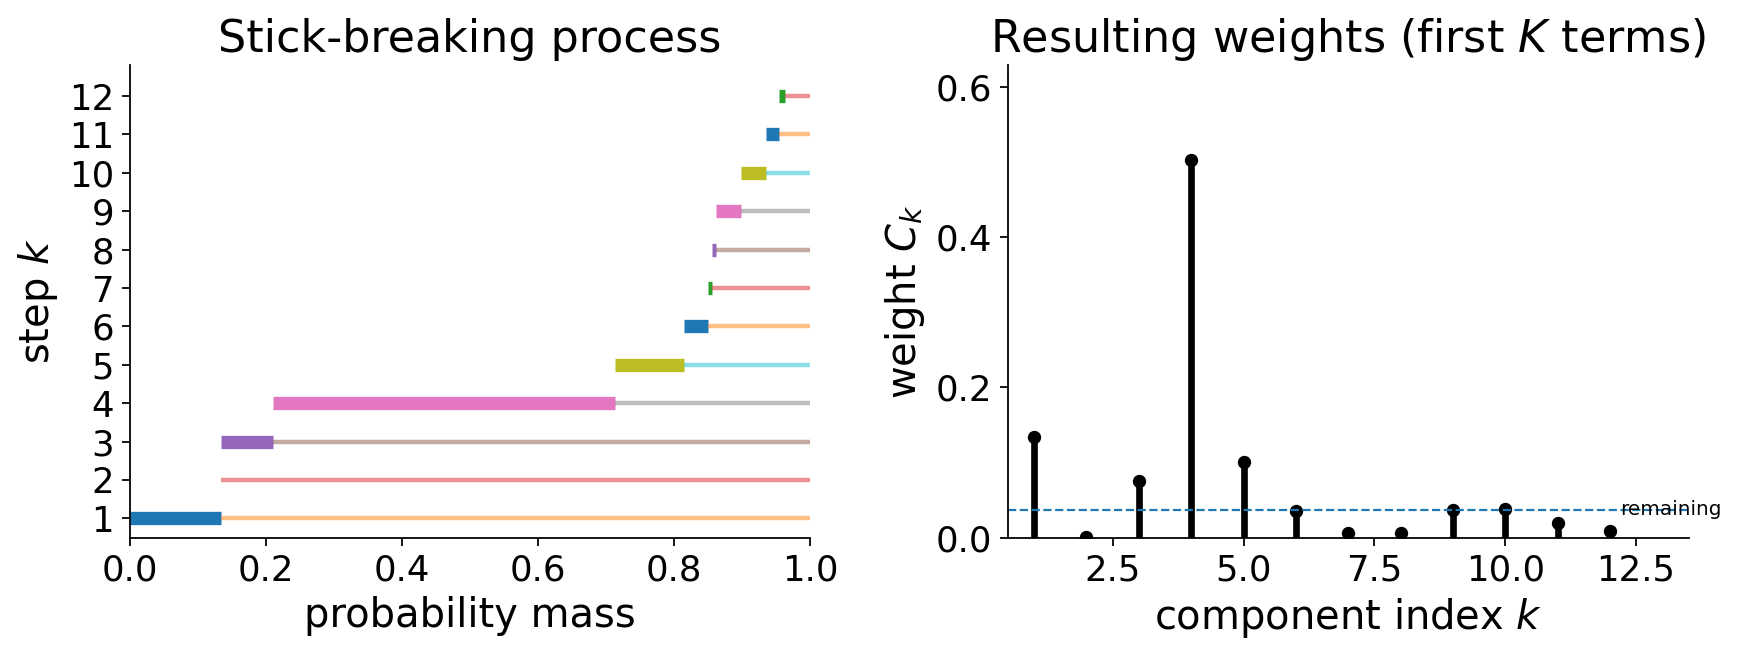

In [38]:
# --- Stick-breaking (GEM / DP weights): V_k ~ Beta(1, alpha) ---
rng = np.random.default_rng(0)
alpha = 5.0          # larger alpha -> more, smaller weights
K = 12                # number of displayed components

V = rng.beta(1.0, alpha, size=K)
C = np.empty(K)
rem = 1.0
for k in range(K):
    C[k] = rem * V[k]
    rem *= (1.0 - V[k])

# --- Two-panel illustration: breaks + resulting weights ---
fig, axes = plt.subplots(1, 2, figsize=(11, 4.2), dpi=160)

# (i) Stick being broken: show remaining stick shrinking and the piece broken off each step
ax = axes[0]
for k in range(K):
    left = C[:k].sum()
    right = left + C[k]
    # broken piece (assigned mass)
    ax.plot([left, right], [k+1, k+1], linewidth=6, solid_capstyle="butt")
    # remaining piece
    ax.plot([right, 1.0], [k+1, k+1], linewidth=2, alpha=0.5, solid_capstyle="butt")
ax.set_xlim(0, 1)
ax.set_ylim(0.5, K + 0.8)
ax.set_yticks(range(1, K+1))
ax.set_xlabel("probability mass")
ax.set_ylabel("step $k$")
ax.set_title("Stick-breaking process")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# (ii) Resulting weights C_k as a discrete distribution (like mixing weights)
ax = axes[1]
k_idx = np.arange(1, K+1)
markerline, stemlines, baseline = ax.stem(k_idx, C, linefmt='k-', markerfmt='o', basefmt=' ')
plt.setp(markerline, markersize=5)
ax.axhline(rem, linestyle="--", linewidth=1)  # leftover mass after K breaks
ax.text(K + 0.2, rem, "remaining", va="center", fontsize=9)
ax.set_xlim(0.5, K + 1.5)
ax.set_ylim(0, max(C.max(), rem) * 1.25)
ax.set_xlabel("component index $k$")
ax.set_ylabel(r"weight $C_k$")
ax.set_title(r"Resulting weights (first $K$ terms)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout(w_pad=2.0)



if print_figs:
    plt.savefig("../img/week4_stick_breaking.pdf", format="pdf", bbox_inches="tight")
    


### 3) DPs with different concentration params

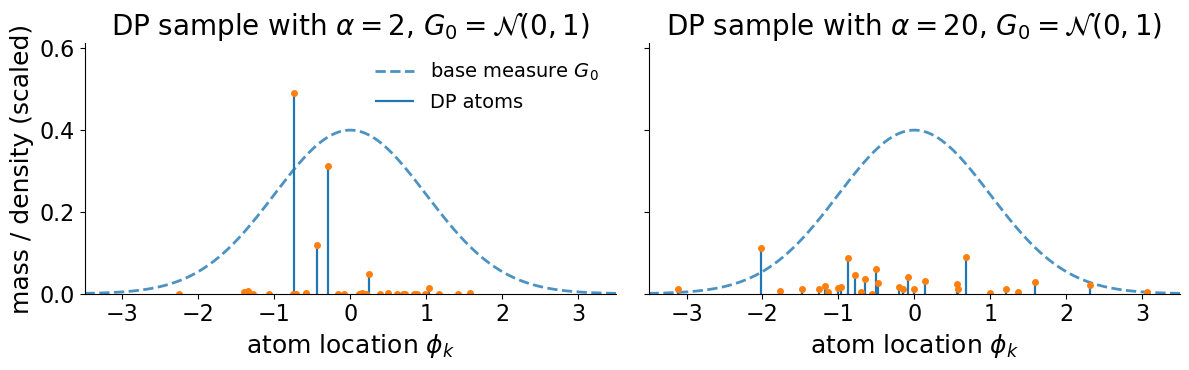

In [49]:
# --- DP draw via stick-breaking + atoms from base measure G0 ---
def sample_dp_atoms(alpha, K, rng):
    # Stick-breaking weights (GEM)
    V = rng.beta(1.0, alpha, size=K)
    w = np.empty(K)
    rem = 1.0
    for k in range(K):
        w[k] = rem * V[k]
        rem *= (1.0 - V[k])

    # Atoms from base measure G0 = N(0,1)
    phi = rng.normal(0.0, 1.0, size=K)

    # Sort by atom location for nicer plotting
    order = np.argsort(phi)
    return phi[order], w[order], rem

# --- setup ---
rng = np.random.default_rng(0)
K = 30
alpha1, alpha2 = 2, 20

phi1, w1, _ = sample_dp_atoms(alpha1, K, rng)
phi2, w2, _ = sample_dp_atoms(alpha2, K, rng)

# Base measure density (Gaussian N(0,1))
x = np.linspace(-3.5, 3.5, 800)
base_pdf = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

# --- plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 3.8), sharey=True)

for ax, phi, w, a in [
    (axes[0], phi1, w1, alpha1),
    (axes[1], phi2, w2, alpha2),
]:
    # Base measure
    ax.plot(x, base_pdf, linestyle="--", linewidth=2.0, alpha=0.8,
            label=r"base measure $G_0$")

    # DP draw: discrete atoms
    ax.vlines(phi, 0.0, w, linewidth=1.6, label="DP atoms")
    ax.plot(phi, w, "o", markersize=4)

    ax.set_title(rf"DP sample with $\alpha={a}$, $G_0=\mathcal{{N}}(0,1)$")
    ax.set_xlabel(r"atom location $\phi_k$")
    ax.set_xlim(x.min(), x.max())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel(r"mass / density (scaled)")
axes[0].set_ylim(0, max(w1.max(), w2.max()) * 1.25)
axes[0].legend(frameon=False)

plt.tight_layout(w_pad=2.0)


if print_figs:
    plt.savefig("../img/week4_2DPs.pdf", format="pdf", bbox_inches="tight")
    

### Bayesian linear model

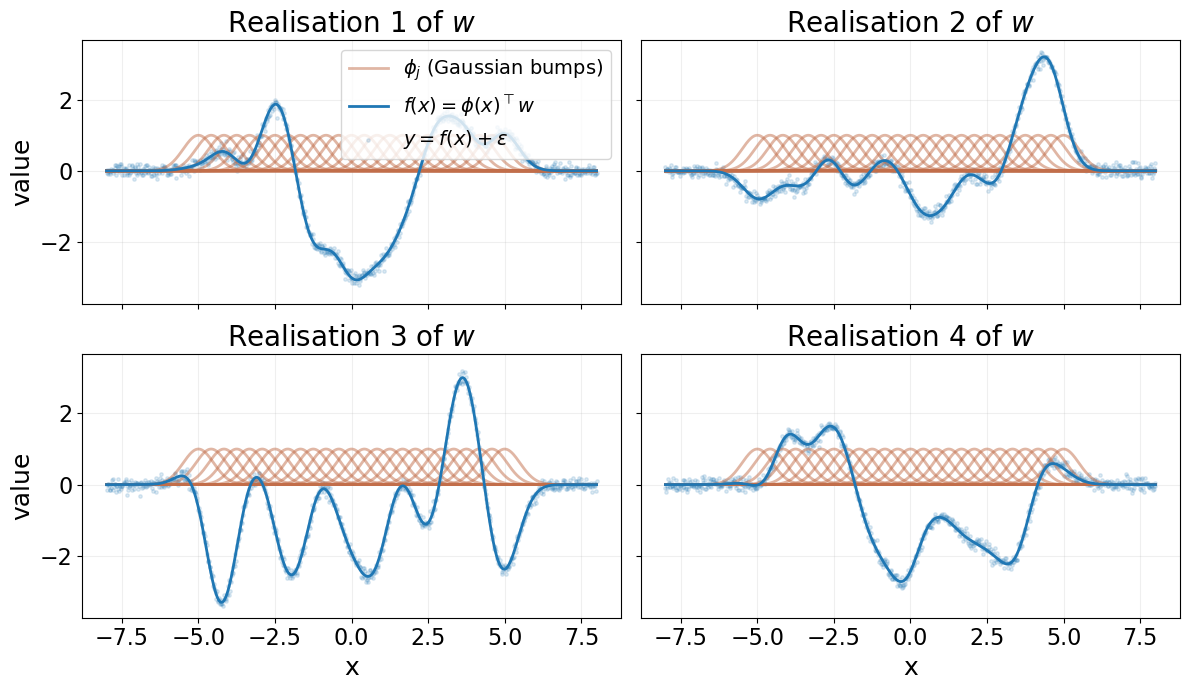

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(0)

# Setup
d = 1
m = 25                 # number of Gaussian bumps
ell = 0.5              # bump width
sigma = 0.1            # noise std (optional; used below)

# Wider input range
x_min, x_max = -8.0, 8.0
N = 800
x_grid = np.linspace(x_min, x_max, N)
X = x_grid[:, None]    # (N, 1)

# Gaussian bump centers (keep them a bit narrower than the plotting window)
centers = np.linspace(-5.0, 5.0, m)[:, None]  # (m, 1)

def phi_gaussian_bumps(X, centers, ell):
    sqdist = np.sum((X[:, None, :] - centers[None, :, :])**2, axis=2)  # (N, m)
    return np.exp(-0.5 * sqdist / ell**2)

# Feature matrix Phi(X) with columns phi_j(x)
Phi = phi_gaussian_bumps(X, centers, ell)  # (N, m)

# ---- Plot: 4 realizations of w ----
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
axes = axes.ravel()

for i, ax in enumerate(axes):
    # New realization of weights
    w = rng.normal(0.0, 1.0, size=m)

    # Latent function
    f = Phi @ w

    # Optional noisy observations (comment out if you only want f)
    y = f + rng.normal(0.0, sigma, size=N)

    # Plot basis functions (phi_j). Add ONE legend entry only.
    for j in range(m):
        label = r"$\phi_j$ (Gaussian bumps)" if j == 0 else None
        ax.plot(x_grid, Phi[:, j], color="#C26E4A", alpha=0.5, linewidth=2, label=label)

    # Plot f(x) and (optionally) y
    ax.plot(x_grid, f, linewidth=2, label=r"$f(x)=\phi(x)^\top w$")
    ax.scatter(x_grid, y, s=6, alpha=0.15, label=r"$y=f(x)+\varepsilon$")

    ax.set_title(f"Realisation {i+1} of $w$")
    ax.grid(True, alpha=0.2)

axes[0].legend(loc="upper right")
for ax in axes[2:]:
    ax.set_xlabel("x")
for ax in axes[0::2]:
    ax.set_ylabel("value")

plt.tight_layout()

if print_figs:
    plt.savefig("../img/week4_Bayesian_linear_model.pdf", format="pdf", bbox_inches="tight")
    
    


### Sample from GPs

/var/folders/hd/761f4bvn2jz3pr3pm02m44k80000gn/T/ipykernel_30364/1847849001.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


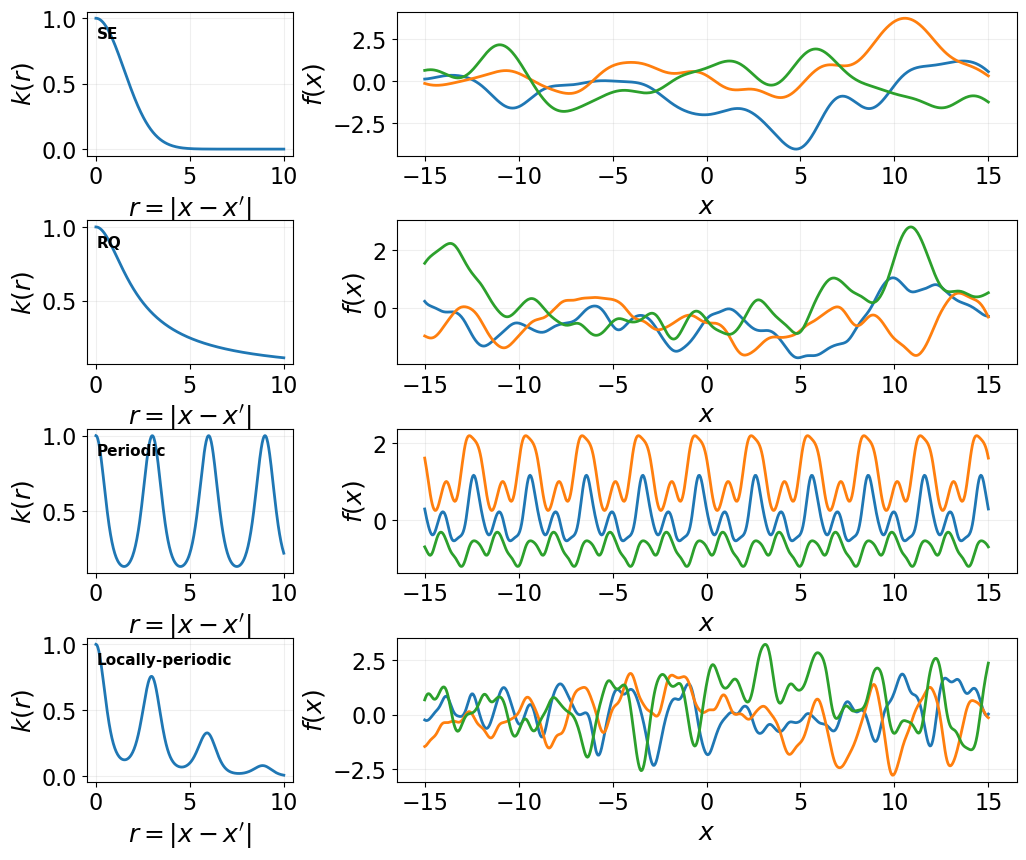

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Kernels (1D)
# -----------------------------
def k_se(x, xp, sigma2=1.0, ell=1.0):
    return sigma2 * np.exp(-0.5 * (x - xp) ** 2 / ell**2)

def k_rq(x, xp, sigma2=1.0, ell=1.0, alpha=1.0):
    return sigma2 * (1.0 + (x - xp) ** 2 / (2.0 * alpha * ell**2)) ** (-alpha)

def k_per(x, xp, sigma2=1.0, ell=1.0, p=1.0):
    r = np.abs(x - xp)
    return sigma2 * np.exp(-2.0 * np.sin(np.pi * r / p) ** 2 / ell**2)

def k_locper(x, xp, sigma2=1.0, ell_se=2.0, ell_per=1.0, p=1.0):
    return k_se(x, xp, 1.0, ell_se) * k_per(x, xp, sigma2, ell_per, p)

# -----------------------------
# GP sampling
# -----------------------------
def gp_samples_1d(x, kernel_fn, n_samples=3, jitter=1e-8, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    K = kernel_fn(x[:, None], x[None, :])
    K += jitter * np.eye(len(x))
    L = np.linalg.cholesky(K)
    return L @ rng.standard_normal((len(x), n_samples))

# -----------------------------
# Main figure
# -----------------------------
rng = np.random.default_rng(0)

# Extended input range
x = np.linspace(-15.0, 15.0, 600)
r = np.linspace(0.0, 10.0, 400)

kernels = [
    ("SE", lambda A, B: k_se(A, B, ell=1.5)),
    ("RQ", lambda A, B: k_rq(A, B, ell=1.5, alpha=0.6)),
    ("Periodic", lambda A, B: k_per(A, B, ell=1.0, p=3.0)),
    ("Locally-periodic", lambda A, B: k_locper(A, B, ell_se=4.0, ell_per=1.0, p=3.0)),
]

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(
    4, 2,
    width_ratios=[1, 3],
    hspace=0.45,
    wspace=0.25
)

for i, (name, kfn) in enumerate(kernels):
    ax_k = fig.add_subplot(gs[i, 0])
    ax_s = fig.add_subplot(gs[i, 1])

    # ---- Left: kernel profile k(r) ----
    k_slice = kfn(np.zeros_like(r), r)
    ax_k.plot(r, k_slice, linewidth=2)
    ax_k.text(
        0.05, 0.90, name,
        transform=ax_k.transAxes,
        fontsize=11,
        fontweight="bold",
        verticalalignment="top"
    )
    ax_k.set_xlabel(r"$r=|x-x'|$")
    ax_k.set_ylabel(r"$k(r)$")
    ax_k.grid(True, alpha=0.2)

    # ---- Right: GP samples ----
    samples = gp_samples_1d(x, lambda A, B: kfn(A, B), n_samples=3, rng=rng)
    for j in range(samples.shape[1]):
        ax_s.plot(x, samples[:, j], linewidth=2)

    ax_s.set_xlabel(r"$x$")
    ax_s.set_ylabel(r"$f(x)$")
    ax_s.grid(True, alpha=0.2)

plt.tight_layout()


if print_figs:
    plt.savefig("../img/week4_GP_samples.pdf", format="pdf", bbox_inches="tight")
    


### Training a GP

/var/folders/hd/761f4bvn2jz3pr3pm02m44k80000gn/T/ipykernel_30364/1382218467.py:92: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(


nit (iterations): 1
message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH


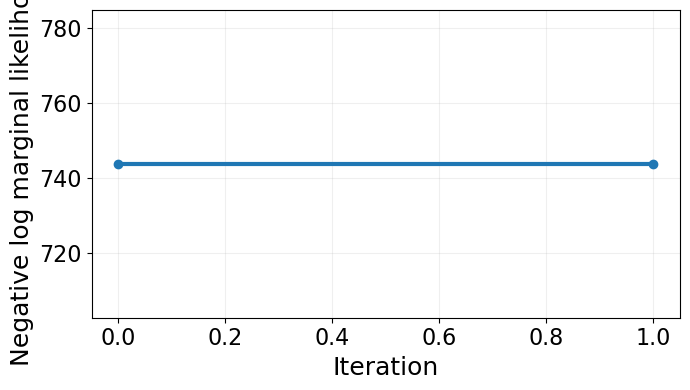

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve

# -----------------------------
# Data: sample 1000 noisy points
# -----------------------------
rng = np.random.default_rng(0)
N = 1000
X = rng.uniform(-10.0, 10.0, size=(N, 1))
X = np.sort(X, axis=0)
x = X[:, 0]

f_true = np.sin(0.8 * x) + 0.3 * np.cos(2.2 * x)
sigma_n_true = 0.2
y = f_true + rng.normal(0.0, sigma_n_true, size=N)

# Precompute squared distances
d2 = (x[:, None] - x[None, :]) ** 2
I = np.eye(N)

# -----------------------------
# SE kernel + noise
# k(x,x') = s_f^2 exp( -0.5 (x-x')^2 / ell^2 ) + s_n^2 delta
# Hyperparameters: ell, s_f^2, s_n^2  (we optimise in log-space)
# -----------------------------
def nll_and_grad(theta_log):
    log_ell, log_sf, log_sn = theta_log
    ell = np.exp(log_ell)
    sf2 = np.exp(2.0 * log_sf)   # marginal variance
    sn2 = np.exp(2.0 * log_sn)   # noise variance

    # Kernel matrix
    E = np.exp(-0.5 * d2 / (ell ** 2))
    K_signal = sf2 * E
    K = K_signal + sn2 * I

    # Cholesky and solves
    cF = cho_factor(K, lower=True, check_finite=False)
    alpha = cho_solve(cF, y, check_finite=False)

    # NLL = 0.5 y^T K^{-1} y + sum log(diag(L)) + 0.5 N log(2pi)
    L = cF[0]
    nll = 0.5 * y @ alpha + np.sum(np.log(np.diag(L))) + 0.5 * N * np.log(2.0 * np.pi)

    # Compute K^{-1} efficiently for gradients via solves
    Kinv = cho_solve(cF, I, check_finite=False)
    B = np.outer(alpha, alpha) - Kinv  # (alpha alpha^T - K^{-1})

    # Derivatives of K w.r.t log-params
    # dK/dlog_sf = 2*K_signal
    dK_log_sf = 2.0 * K_signal

    # dK/dlog_ell = K_signal * (d2 / ell^2)
    dK_log_ell = K_signal * (d2 / (ell ** 2))

    # dK/dlog_sn = 2*sn2*I
    dK_log_sn = 2.0 * sn2 * I

    # grad = 0.5 * trace( B^T dK/dtheta ) = 0.5 * sum(B * dK)
    grad_log_ell = 0.5 * np.sum(B * dK_log_ell)
    grad_log_sf  = 0.5 * np.sum(B * dK_log_sf)
    grad_log_sn  = 0.5 * np.sum(B * dK_log_sn)

    grad = np.array([grad_log_ell, grad_log_sf, grad_log_sn], dtype=float)
    return nll, grad

# -----------------------------
# Optimisation with callback to record loss per iteration
# -----------------------------
loss_trace = []

def callback(theta_log):
    nll, _ = nll_and_grad(theta_log)
    loss_trace.append(nll)

# Initial guess (log-space)
theta0 = np.log([1.0, 1.0, 0.1])  # [ell, sf, sn]  (note: sf and sn are std-like here)
# --- before calling minimize ---
loss_trace = []

def nll_only(t):
    return nll_and_grad(t)[0]

# record initial value so the curve always has a start point
loss_trace.append(nll_only(theta0))

def callback(theta_log):
    loss_trace.append(nll_only(theta_log))

res = minimize(
    fun=lambda t: nll_and_grad(t)[0],
    x0=theta0,
    jac=lambda t: nll_and_grad(t)[1],
    method="L-BFGS-B",
    callback=callback,
    options={
        "maxiter": 200,
        "disp": True,
        "gtol": 1e-10,     # stricter gradient tolerance
        "ftol": 1e-12      # stricter function tolerance
    }
)

print("nit (iterations):", res.nit)
print("message:", res.message)

# --- plot ---
plt.figure(figsize=(7, 4))
plt.plot(np.arange(len(loss_trace)), loss_trace, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Negative log marginal likelihood")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()
